## Development
I was inspired to build a hit classification model during my time working as an intern for the Joliet Slammers as a baseball analyst. I wanted to be able to derive metrics like xwOBA, xBA, etc. I found an already well-developed model at https://github.com/tjburch/mlb-hit-classifier, and the following notebooks and code take ideas from it, especially incorporating spray angle/direction to the model's features. My goal was to build a model that performed on a similar level as TJ's and the MLB's.

In [77]:
from pybaseball import statcast, cache
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib
from tqdm import tqdm
cache.enable()

In [78]:
data = statcast('2022-04-01', '2022-10-05')

This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████| 188/188 [01:28<00:00,  2.11it/s]


Deriving spray angle in order to boost model's performance (~3% accuracy and precision)

In [79]:
data["spray_angle"] = np.arctan((data["hc_x"]-125.42)/(198.27-data["hc_y"]))*180/np.pi*.75

In [83]:
columns = ['events', 'launch_speed', 'launch_angle', 'spray_angle']
features = ['launch_speed', 'launch_angle', 'spray_angle']
care_about = ['home_run', 'field_out', 'single', 'double', 'triple']
filtered_df = data[data['events'].isin(care_about)].loc[:, data.columns.isin(columns)].dropna().reset_index(drop=True)

Plotting launch angle vs. exit velo...

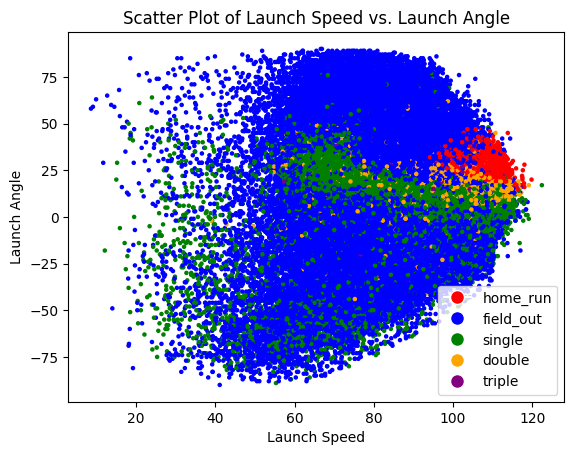

In [84]:
color_dict = {
    'home_run': 'red',
    'field_out': 'blue',
    'single': 'green',
    'double': 'orange',
    'triple': 'purple'
}

plt.scatter(
    filtered_df['launch_speed'],
    filtered_df['launch_angle'],
    c=filtered_df['events'].map(color_dict),
    s=5
)

legend_handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, markersize=10, label=event) for event, color in color_dict.items()]
plt.legend(handles=legend_handles)

plt.xlabel('Launch Speed')
plt.ylabel('Launch Angle')
plt.title('Scatter Plot of Launch Speed vs. Launch Angle')

plt.show()

Now to start modeling, we break down our data into target and features and encode the events for the model

In [85]:
X = filtered_df[features]
le = LabelEncoder()
y = filtered_df.events
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, random_state=1)

Fitting an XGBClassifier with generic parameters and seeing where we're at...

In [86]:
gb = XGBClassifier()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)

X_test["GB Prediction"] = le.inverse_transform(gb_pred)
X_test["Truth"] = le.inverse_transform(y_test)

Plot of predicted looks pretty good, don't see any triples, bunts are really hard to classify. I think top speed would improve the model by a few percentage points, but because one of the main purposes of this model is to derive xStats for the Frontier League, who we don't have speed data on, we have to go without it

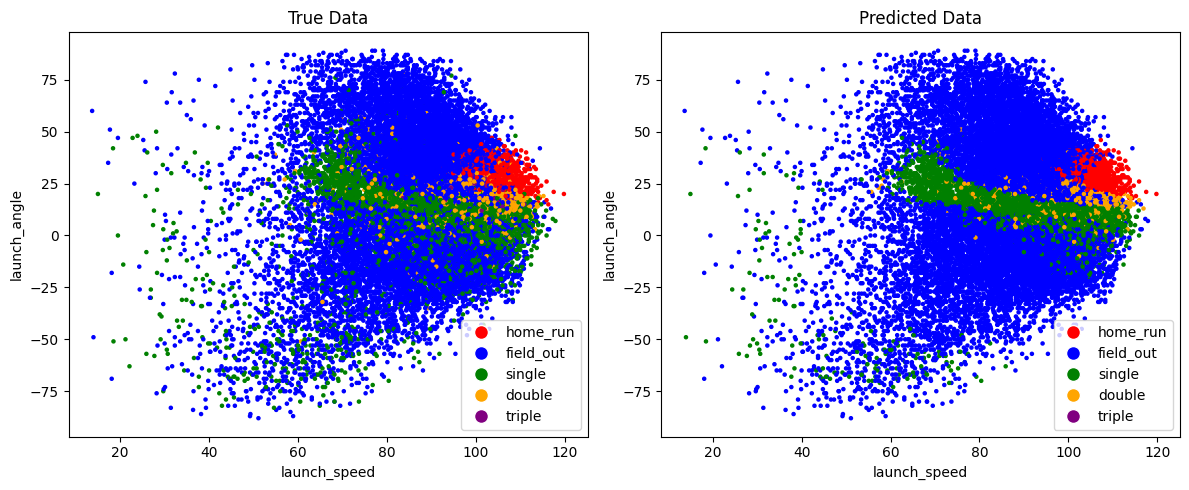

In [87]:
true_data = X_test.drop(columns=["GB Prediction"])
predicted_data = X_test.drop(columns=["Truth"])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

scatter_true = ax1.scatter(
    true_data['launch_speed'],
    true_data['launch_angle'],
    c=true_data['Truth'].map(color_dict),
    s=5,
    label='True Data'
)
ax1.set_xlabel('launch_speed')
ax1.set_ylabel('launch_angle')
ax1.set_title('True Data')

scatter_pred = ax2.scatter(
    predicted_data['launch_speed'],
    predicted_data['launch_angle'],
    c=predicted_data['GB Prediction'].map(color_dict),
    s=5,
    label='Predicted Data'
)
ax2.set_xlabel('launch_speed')
ax2.set_ylabel('launch_angle')
ax2.set_title('Predicted Data')


legend_handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, markersize=10, label=event) for event, color in color_dict.items()]
ax1.legend(handles=legend_handles), ax2.legend(handles=legend_handles)

plt.tight_layout()
plt.show()

Do the same thing with some other classification models to see if there is a difference...

In [88]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test[features])

X_test["RF Prediction"] = le.inverse_transform(rf_pred)

In [89]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test[features])

X_test["KNN Prediction"] = le.inverse_transform(knn_pred)

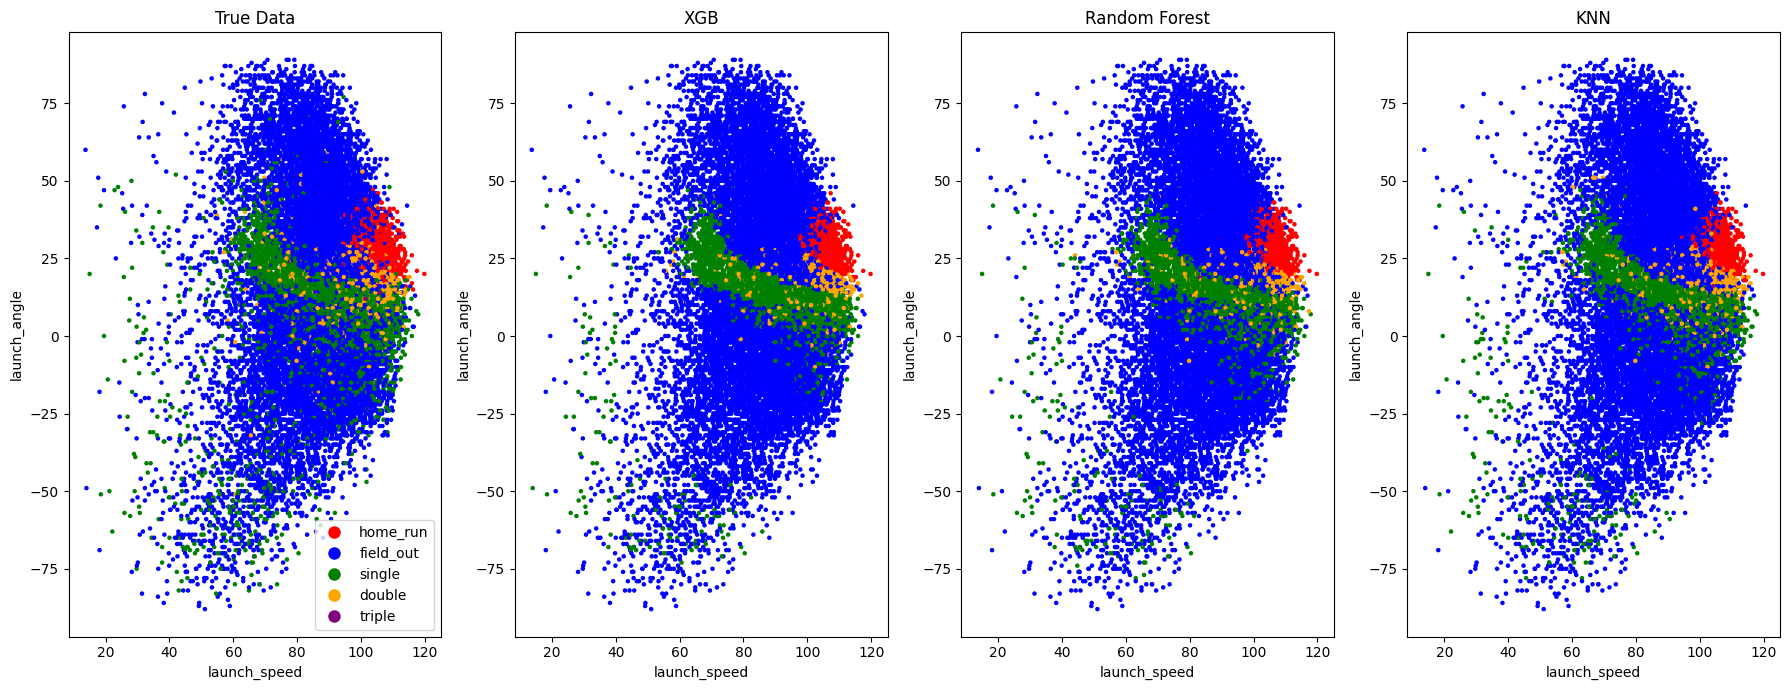

In [90]:
true_data = X_test.drop(columns=["GB Prediction", "RF Prediction", "KNN Prediction"])
predicted_data = X_test.drop(columns=["Truth"])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18, 7))

scatter_true = ax1.scatter(
    true_data['launch_speed'],
    true_data['launch_angle'],
    c=true_data['Truth'].map(color_dict),
    s=5,
    label='True Data'
)
ax1.set_xlabel('launch_speed')
ax1.set_ylabel('launch_angle')
ax1.set_title('True Data')

scatter_pred = ax2.scatter(
    predicted_data['launch_speed'],
    predicted_data['launch_angle'],
    c=predicted_data['GB Prediction'].map(color_dict),
    s=5,
    label='Predicted Data'
)
ax2.set_xlabel('launch_speed')
ax2.set_ylabel('launch_angle')
ax2.set_title('XGB')

scatter_pred = ax3.scatter(
    predicted_data['launch_speed'],
    predicted_data['launch_angle'],
    c=predicted_data['RF Prediction'].map(color_dict),
    s=5,
    label='Predicted Data'
)
ax3.set_xlabel('launch_speed')
ax3.set_ylabel('launch_angle')
ax3.set_title('Random Forest')

scatter_pred = ax4.scatter(
    predicted_data['launch_speed'],
    predicted_data['launch_angle'],
    c=predicted_data['KNN Prediction'].map(color_dict),
    s=5,
    label='Predicted Data'
)
ax4.set_xlabel('launch_speed')
ax4.set_ylabel('launch_angle')
ax4.set_title('KNN')

legend_handles = [plt.Line2D([], [], marker='o', color='w', markerfacecolor=color, markersize=10, label=event) for event, color in color_dict.items()]
ax1.legend(handles=legend_handles)

plt.tight_layout()
plt.show()

All three models look pretty good; let's get some objective statistics to evaluate...

In [91]:
true_labels = true_data['Truth']
gb_pred, rf_pred, knn_pred = le.inverse_transform(gb_pred), le.inverse_transform(rf_pred), le.inverse_transform(knn_pred)

gb_accuracy = accuracy_score(true_labels, gb_pred)
rf_accuracy = accuracy_score(true_labels, rf_pred)
knn_accuracy = accuracy_score(true_labels, knn_pred)

gb_precision = precision_score(true_labels, gb_pred, average='weighted')
rf_precision = precision_score(true_labels, rf_pred, average='weighted')
knn_precision = precision_score(true_labels, knn_pred, average='weighted')

print("XGBoost Accuracy:", gb_accuracy)
print("XGBoost Precision:", gb_precision, '\n')
print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Precision:", rf_precision, '\n')
print("K-Nearest Neighbors Accuracy:", knn_accuracy)
print("K-Nearest Neighbors Precision:", knn_precision)

XGBoost Accuracy: 0.7963279435607554
XGBoost Precision: 0.7843118008209347 

Random Forest Accuracy: 0.7804215415625958
Random Forest Precision: 0.7684734353833073 

K-Nearest Neighbors Accuracy: 0.7746812146706981
K-Nearest Neighbors Precision: 0.7632834589302445


Trying to see if one model does a better job at predicting a particular batted ball event than another...

In [92]:
gb_pred_counts = X_test["GB Prediction"].value_counts()
gb_pred_percentages = X_test["GB Prediction"].value_counts(normalize=True) * 100
knn_pred_counts = X_test["KNN Prediction"].value_counts()
knn_pred_percentages = X_test["KNN Prediction"].value_counts(normalize=True) * 100
rf_pred_counts = X_test["RF Prediction"].value_counts()
rf_pred_percentages = X_test["RF Prediction"].value_counts(normalize=True) * 100

true_counts = X_test["Truth"].value_counts()
true_percentages = X_test["Truth"].value_counts(normalize=True) * 100

print("XGB - Predicted Percentages:")
print(gb_pred_percentages, '\n')
print("KNN - Predicted Percentages:")
print(knn_pred_percentages, '\n')
print("RF - Predicted Percentages:")
print(rf_pred_percentages, '\n')
print("Actual - True Percentages:")
print(true_percentages)

XGB - Predicted Percentages:
field_out    69.909294
single       20.297095
double        5.140003
home_run      4.644845
triple        0.008764
Name: GB Prediction, dtype: float64 

KNN - Predicted Percentages:
field_out    69.501775
single       19.657333
double        6.423908
home_run      4.395075
triple        0.021910
Name: KNN Prediction, dtype: float64 

RF - Predicted Percentages:
field_out    69.975023
single       19.915867
double        5.424828
home_run      4.552824
triple        0.131458
Name: RF Prediction, dtype: float64 

Actual - True Percentages:
field_out    65.076026
single       22.619517
double        7.028614
home_run      4.688664
triple        0.587178
Name: Truth, dtype: float64


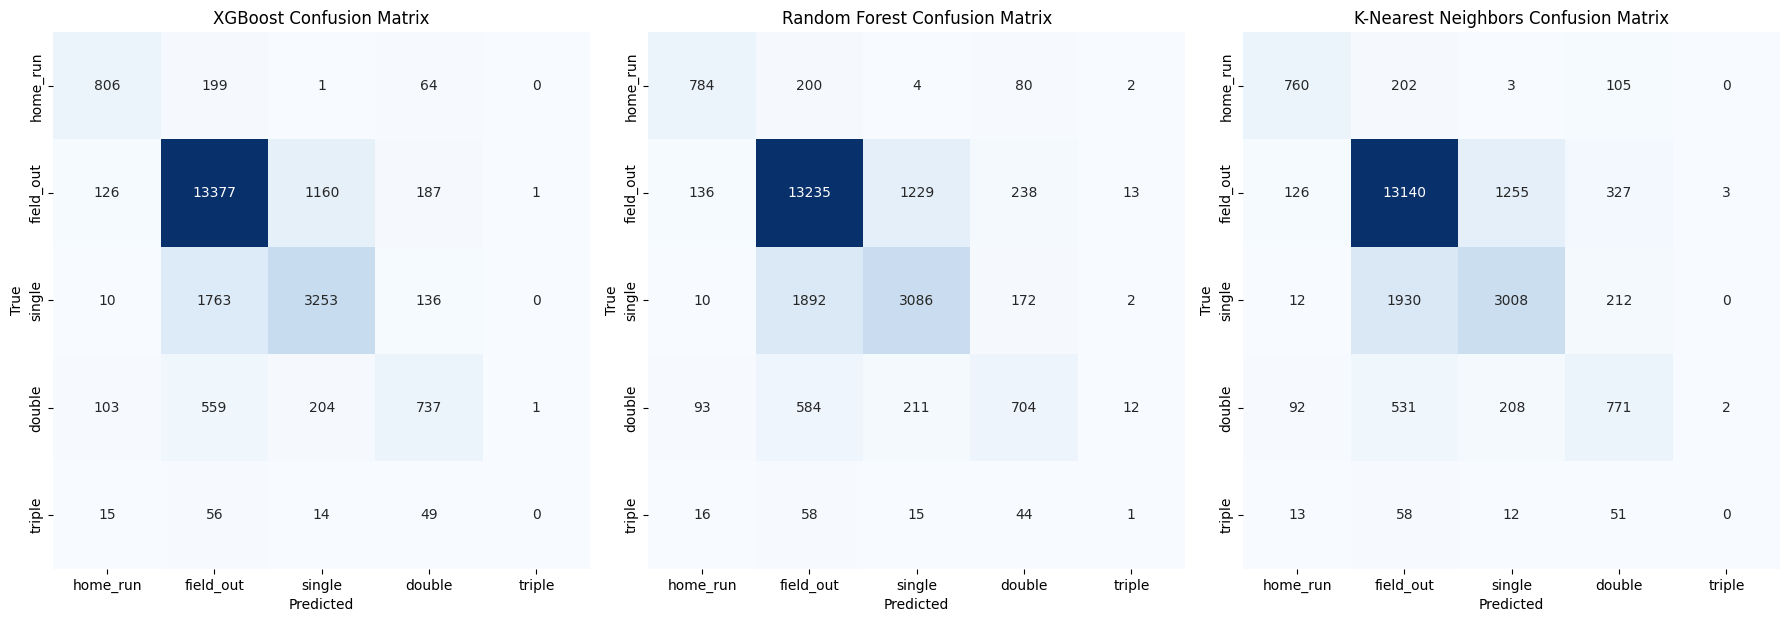

In [97]:
class_labels = care_about

gb_cm = confusion_matrix(true_labels, gb_pred, labels=class_labels)
rf_cm = confusion_matrix(true_labels, rf_pred, labels=class_labels)
knn_cm = confusion_matrix(true_labels, knn_pred, labels=class_labels)

def plot_confusion_matrix(cm, class_labels, title, ax):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True, xticklabels=class_labels, yticklabels=class_labels, ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plot_confusion_matrix(gb_cm, class_labels, "XGBoost Confusion Matrix", axs[0])
plot_confusion_matrix(rf_cm, class_labels, "Random Forest Confusion Matrix", axs[1])
plot_confusion_matrix(knn_cm, class_labels, "K-Nearest Neighbors Confusion Matrix", axs[2])

plt.tight_layout()

plt.show()